# Baseline model : bicubic interpolation

In [11]:
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

In [12]:
dir_low_enhanced = 'data/enhanced/low'
dir_high_enhanced = 'data/enhanced/high'
in_size = (40, 120)
out_size = (80, 240)

In [60]:
def bicubic_upscale(image_num, plot=False):
    path = f"{dir_low_enhanced}/{str(image_num)}.tiff"
    if not os.path.exists(path): return None

    img = Image.open(path)
    img = img.convert('RGB') if img.mode in ['P', 'RGBA'] else img

    # Upscale & Sharpen
    up = img.resize(out_size, resample=Image.Resampling.BICUBIC)
    final = up.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=1))

    os.makedirs(dir_high_enhanced, exist_ok=True)
    final.save(f"{dir_high_enhanced}/{str(image_num)}.tiff")

    if plot:
        # ANALYSIS: "High-Pass" Residuals
        arr_img = np.array(final).astype(float)
        # Radius=1 is key here: it isolates strictly pixel-to-pixel deviations
        arr_blur = np.array(final.filter(ImageFilter.GaussianBlur(radius=1))).astype(float)
        
        diff = np.abs(arr_img - arr_blur)
        if diff.ndim == 3: diff = np.mean(diff, axis=2)

        # PLOTTING
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        
        # 1. Output
        ax[0].imshow(final, cmap=None if final.mode=='RGB' else 'gray', aspect='equal')
        ax[0].set_title("Output")

        # 2. Intensity Heatmap (Turbo)
        ax[1].imshow(final.convert('L'), cmap='turbo', aspect='equal')
        ax[1].set_title("Global Intensity Shifts")

        # 3. Ultra-Fine Variations (Magma)
        # vmax=5 makes the plot EXTREMELY sensitive to tiny noise/changes
        im = ax[2].imshow(diff, cmap='magma', aspect='equal', vmin=0, vmax=5)
        ax[2].set_title("Pixel-Level Micro-Variations")
        
        for a in ax: a.axis('off')
        plt.colorbar(im, ax=ax[2], fraction=0.05)
        plt.tight_layout()
        plt.show()

    return final

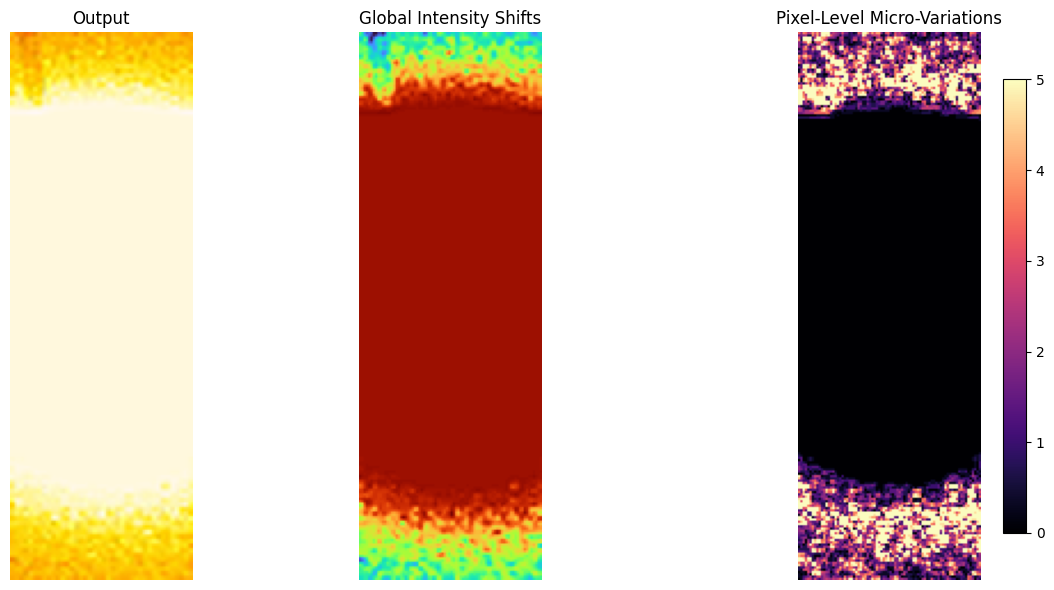

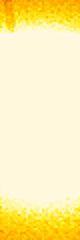

In [61]:
bicubic_upscale(0, plot=True)

In [206]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# Config
dir_low_enhanced = 'data/CFRP_60_low'
dir_high_enhanced = 'data/CFRP_60_high'

def process_full_cmyk(image_num, plot=False):
    # 1. Chargement
    path = f"{dir_low_enhanced}/Record_2025-11-11_10-42-17.tiff"
    
    if not os.path.exists(path): 
        print(f"Fichier introuvable : {path}")
        return None

    img = Image.open(path)
    img = img.convert('CMYK')

    # 2. Traitement Global (Netteté)
    final = img.filter(ImageFilter.UnsharpMask(radius=2, percent=50, threshold=100))

    # 3. Sauvegarde
    os.makedirs(dir_high_enhanced, exist_ok=True)
    final.save(f"{dir_high_enhanced}/{str(image_num)}.tiff")

    if plot:
        channels = final.split()
        channel_names = ['Cyan', 'Magenta', 'Yellow', 'Key (Black)']
        
        # Configuration de la figure : 4 lignes (CMYK), 2 colonnes (Image, Texture)
        # J'ajuste la hauteur (figsize) car les images entières sont hautes
        fig, axes = plt.subplots(4, 2, figsize=(8, 20))
        
        for i, (chan_img, name) in enumerate(zip(channels, channel_names)):
            
            # --- ANALYSE TEXTURE (Sur toute l'image) ---
            arr_img = np.array(chan_img).astype(float)
            
            # Filtre passe-haut : Image - Image Floue
            # radius=14 est large (détecte les zones), radius=1 détecterait le grain fin.
            blur_img = chan_img.filter(ImageFilter.GaussianBlur(radius=14))
            arr_blur = np.array(blur_img).astype(float)
            
            diff = np.abs(arr_img - arr_blur)

            # --- AFFICHAGE ---
            
            # Col 1: Image Complète (Niveaux de gris)
            axes[i, 0].imshow(chan_img, cmap='gray', aspect='equal')
            axes[i, 0].set_ylabel(name, fontsize=12, fontweight='bold')
            if i == 0: axes[i, 0].set_title("Full Channel")
            
            # Col 2: Texture / Micro-Variations (Magma)
            # vmin/vmax=5 permet de saturer le contraste pour voir les défauts invisibles
            im = axes[i, 1].imshow(diff, cmap='magma', aspect='equal', vmin=0, vmax=5)
            if i == 0: axes[i, 1].set_title("Texture Analysis")
            
            # Nettoyage axes
            for j in range(2):
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])

        # Barre de couleur
        plt.colorbar(im, ax=axes[:, 1], fraction=0.05, label='Texture Intensity (0-5)')
        plt.suptitle(f"Full Image CMYK Analysis", fontsize=16, y=1.005) # y ajuste la position du titre
        plt.tight_layout()
        plt.show()

    return final

# process_full_cmyk("test_full_cmyk", plot=True)

C:\Users\tchir\AppData\Local\Temp\ipykernel_6116\71484535.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


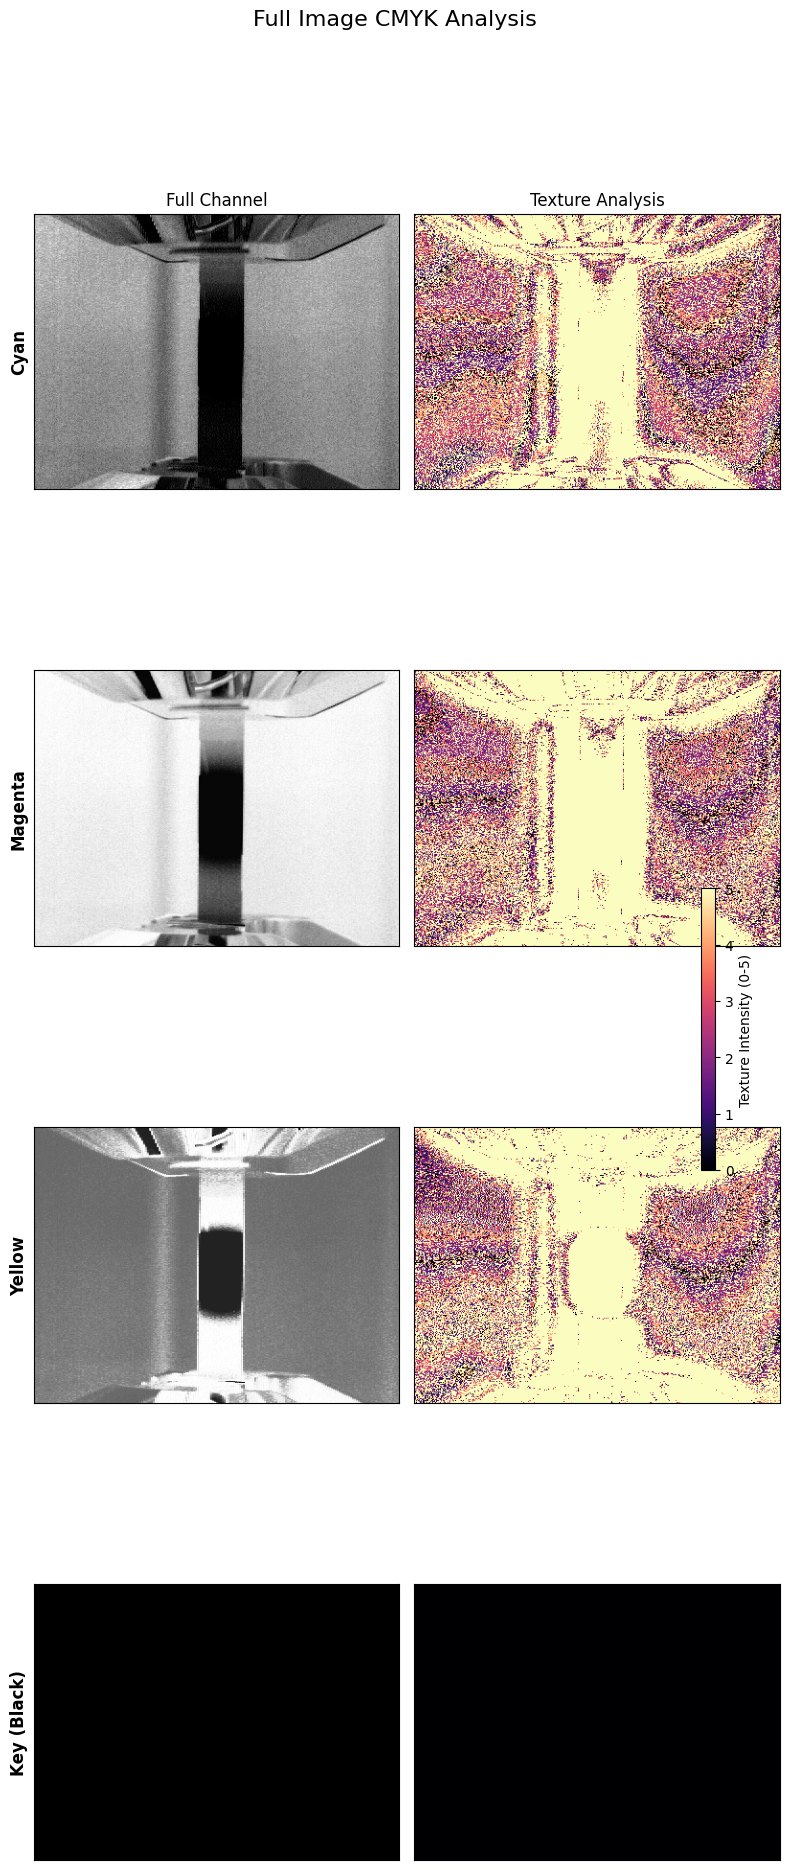

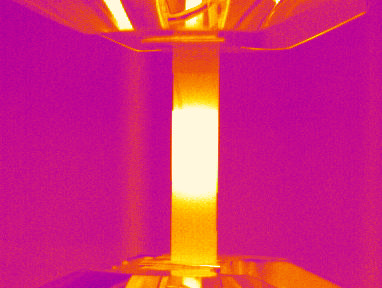

In [207]:
process_full_cmyk('Record_2025-11-11_10-50-02.tiff', plot=True)